Name: Holly Kular\
Date: 03-19-2024\
Email: hkular@ucsd.edu\
decode_L1_stimvschoice\
Description: Script for decoding analysis on layer 1 of probabilistic RNN

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [93]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification  
from scipy.optimize import curve_fit
from multiprocessing import Pool

In [78]:
# MODIFY HERE
# what conditions were the RNNs trained on?
prob_split = '70_30' # the probability of stimulus 1 vs all
afc = '2' # number of alternatives
coh = 'lo' # coherence
feedback = False # interlayer feedback (true or false)
thresh = [ 0.3,0.7 ] # threshold for whether stim 1 or other

# decode opts
time_avg = False # do we want to look at average over time window?
if time_avg:
    t_win = [ 200,-1 ]
n_cvs = 5
# store the accuracy
acc = np.full( ( n_cvs ), np.nan )

# penalties to eval
num_cgs = 30
Cs = np.logspace( -5,1,num_cgs )

# set up the grid
param_grid = { 'C': Cs, 'kernel': ['linear'] }

# define object - use a SVC that balances class weights (because they are biased, e.g. 70/30)
# note that can also specify cv folds here, but I'm doing it by hand below in a loop
grid = GridSearchCV( SVC(class_weight = 'balanced'),param_grid,refit=True,verbose=0 )


In [79]:
# Data Directory
if sys.platform.startswith('linux'):
    data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_{prob_split}_{afc}afc/feedforward_only/{coh}_coh"
else:
    data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_{prob_split}_{afc}afc/feedforward_only/{coh}_coh"

# Load data
#data = np.load(f"{data_dir}/Trials.npz")
data = np.load(f"{data_dir}/Trials200_0expected.npz")
task_info = {}
task_info['trials'] = 200
task_info['trial_dur'] = 250  # trial duration (timesteps)
task_info['stim_on'] = 80
task_info['stim_dur'] = 50

In [80]:
# make a progress bar for decoding that takes more than 1s
def update_progress(progress, total):
    bar_length = 20  # Adjust this for desired bar length
    filled_length = int(round(progress / total * bar_length))
    bar = '=' * filled_length + '-' * (bar_length - filled_length)
    print(f'Progress: [{bar}] {progress}/{total}', end='\r')

In [ ]:
# define fitting model for parallelization
def fit_and_score_cv(t_step, data_slice, tri_ind, hold_out, n_cvs, labs, thresh, grid):
    """
    Fits the model on each CV fold for a given time step

    Args:
      t_step: The time step index.
      data_slice: The data slice for the current time step.
      tri_ind: Indices of all trials.
      hold_out: Number of trials to hold out for testing in each fold.
      n_cvs: Number of CV folds.
      labs: Labels for all trials.
      thresh: Thresholds for binary classification.
      grid: scikit-learn GridSearchCV object.

    Returns:
      A list of accuracies for each CV fold for the given time step.
    """
    acc = []
    for i in range(n_cvs):
        # loop over CV folds within each t_step
        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        X = data_slice[trn_ind,:]
        y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)

        # fit the model
        grid.fit( X,y )

        # get the test data (X) and the test labels (y)
        X_test = data_slice[tst_ind, :]
        y_test = np.select([labs[tst_ind] >= thresh[1], labs[tst_ind] <= thresh[0]], [0,1], default=0)

        # predict!
        score = grid.score( X_test,y_test )
        acc.append(score)  # Append accuracy for this CV fold
    return acc


## Compare decode choice vs. stim
Hypothesis: We can decode stimulus better than choice from layer 1 because of a more sensory-like format

### Decode choice

In [81]:
# Decode trials: RNN stim choice
# get the data from layer 1 decode choice
# this is a [trial x time step x unit] matrix
data_d = data['fr1']
labs = data['outs'][:,-1]

In [82]:
# average if needed and pick trials
if time_avg:
    data_d = np.mean( data_d[ :,t_win[0]:t_win[1], : ], axis = 1 )# avg over time window

# get some info about structure of the data
tris = data_d.shape[0]             # number of trials
tri_ind = np.arange(0,tris)      # list from 0...tris
hold_out = int( tris / n_cvs )   # how many trials to hold out

In [83]:
# Do decoding
if time_avg:
       # don't need to run parallel
        # Within each cross-validation fold
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        X = data_d[ trn_ind,: ]
        y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [ 0,1 ], default=0)#np.select([labs[trn_ind] >= thresh], [1], default=0) 

        # Fit the model on the binary labels
        grid.fit( X, y )

        # get the test data (X) and the test labels (y)
        X_test = data_d[tst_ind, :]
        y_test = np.select([labs[tst_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [ 0,1 ], default=0)

        # predict!
        acc[ i ] = grid.score( X_test,y_test )

        # Evaluate accuracy
        accuracy = np.mean( acc )
        # Print overall results
        print(f'CV: {i}, {grid.best_estimator_}')  
        
else:
    # run in parallel over time steps
    total_iterations = task_info['trial_dur'] * n_cvs
    decoding_acc = np.zeros((task_info['trial_dur'],))
    for t_step in range(task_info['trial_dur']):

        data_slice = data_d[:, t_step, :]

        # loop over cvs and do classification
        for i in range(n_cvs):

            # trials to hold out as test set on this cv fold
            tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

            # index into the training data on this cv fold
            trn_ind = np.setdiff1d( tri_ind, tst_ind )

            # get the training data (X) and the training labels (y)
            X = data_slice[trn_ind,:]
            y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)

            # fit the model
            grid.fit( X,y )

            # progress report
            #print(f'CV: {i}, {grid.best_estimator_}')

            # get the test data (X) and the test labels (y)
            X_test = data_slice[tst_ind, :]
            y_test = np.select([labs[tst_ind] >= thresh[1], labs[tst_ind] <= thresh[0]], [0,1], default=0)

            # predict!
            acc[ i ] = grid.score( X_test,y_test )
            update_progress((t_step * n_cvs) + i + 1, total_iterations)
        decoding_acc[t_step] = np.mean(acc)        
    plots = True # show decoding acc over time
    print('')  # Print a newline after the progress bar    
print(f'done decoding')



Progress: [====================] 1250/1250
done decoding


In [ ]:
if __name__ == "__main__":
  # ... (your existing code)

  with Pool(processes=round(os.cpu_count()*.7))  # use 70% of cpus
    results = pool.starmap(fit_and_score_cv, [
        (t_step, data_d[:, t_step, :], tri_ind, hold_out, n_cvs, labs, thresh, grid)
        for t_step in range(task_info['trial_dur'])
    ])

  # Process the results from each worker process (list of lists of accuracies)
  decoding_acc = np.mean(np.array(results), axis=1)  # Calculate mean accuracy for each time step
  # ... (rest of your code)

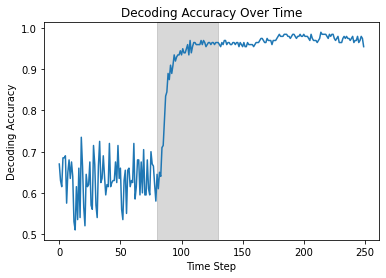

In [86]:
if plots:
    # Plot decoding accuracy over time
    plt.figure()
    plt.plot(range(task_info['trial_dur']), decoding_acc)
    plt.xlabel('Time Step')
    plt.ylabel('Decoding Accuracy')
    plt.title('Decoding Accuracy Over Time')
    plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
    #plt.savefig(f"{data_dir}/decode_choice.png")
    plt.show()  

Estimated y-value of the asymptote: 0.9680707517292327


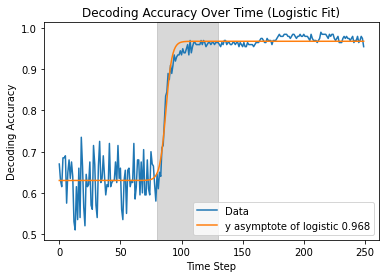

In [92]:
# fit logistic function
def logistic_func(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

popt, _ = curve_fit(logistic_func, range(0, task_info['trial_dur']), decoding_acc[0:])

# 'popt' will contain the fitted parameters (a, b, c) of the log function

# Optional: Estimate the y-value of the asymptote (assuming based on parameter a)
asymptote_y = popt[1]
print("Estimated y-value of the asymptote:", asymptote_y)

# Optional: Visualization
plt.plot(range(0, task_info['trial_dur']), decoding_acc[0:], label='Data')
plt.plot(range(0, task_info['trial_dur']), logistic_func(range(0, task_info['trial_dur']), *popt), label=f'y asymptote of logistic {round(asymptote_y, 3)}')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time (Logistic Fit)')
plt.legend()
#plt.savefig(f"{data_dir}/decode_choicefit.png")
plt.show()

### Decode stim

In [57]:
# Decode trials: RNN stim presented

# get the data from layer 1 decode stim
# this is a [trial x time step x unit] matrix
data_d = data['fr1']
labs = data['labs'].squeeze()

# average if needed and pick trials
if time_avg:
    data_d = np.mean( data_d[ :,t_win[0]:t_win[1], : ], axis = 1 )# avg over time window

# get some info about structure of the data
tris = data_d.shape[0]             # number of trials
tri_ind = np.arange(0,tris)      # list from 0...tris
hold_out = int( tris / n_cvs )   # how many trials to hold out

Progress: [====================] 1250/1250
done decoding


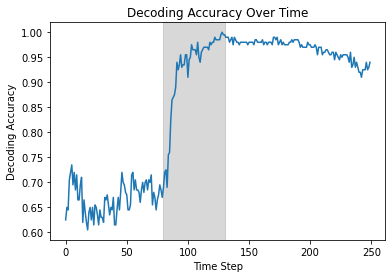

In [58]:
# Do decoding
if time_avg:
       
        # Within each cross-validation fold
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        # note that y is unbalanced unless prob is 50/50
        X = data_d[ trn_ind,: ]
        y = labs[trn_ind]

        # Fit the model on the binary labels
        grid.fit( X, y )

        # get the test data (X) and the test labels (y)
        X_test = data_d[tst_ind, :]
        y_test = labs[tst_ind]

        # predict!
        acc[ i ] = grid.score( X_test,y_test )

        # Evaluate accuracy
        accuracy = np.mean( acc )
        # Print overall results
        print(f'CV: {i}, {grid.best_estimator_}')  
        
else:
    
    total_iterations = task_info['trial_dur'] * n_cvs
    decoding_acc = np.zeros((task_info['trial_dur'],))
    for t_step in range(task_info['trial_dur']):

        data_slice = data_d[:, t_step, :]

        # loop over cvs and do classification
        for i in range(n_cvs):

            # trials to hold out as test set on this cv fold
            tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

            # index into the training data on this cv fold
            trn_ind = np.setdiff1d( tri_ind, tst_ind )

            # get the training data (X) and the training labels (y)
            X = data_slice[trn_ind,:]
            y = labs[trn_ind] 

            # fit the model
            grid.fit( X,y )

            # progress report
            #print(f'CV: {i}, {grid.best_estimator_}')

            # get the test data (X) and the test labels (y)
            X_test = data_slice[tst_ind, :]
            y_test = labs[tst_ind]

            # predict!
            acc[ i ] = grid.score( X_test,y_test )
            update_progress((t_step * n_cvs) + i + 1, total_iterations)
        decoding_acc[t_step] = np.mean(acc)        
    plots = True # show decoding acc over time
    print('')  # Print a newline after the progress bar    
print(f'done decoding')

if plots:
    # Plot decoding accuracy over time
    plt.figure()
    plt.plot(range(task_info['trial_dur']), decoding_acc)
    plt.xlabel('Time Step')
    plt.ylabel('Decoding Accuracy')
    plt.title('Decoding Accuracy Over Time')
    plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
    #plt.savefig(f"{data_dir}/decode_stim.png")
    plt.show()  

Estimated y-value of the asymptote: 0.9678202794816257


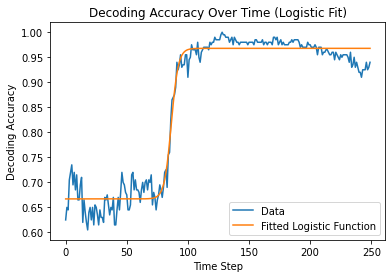

In [60]:
# fit logistic function
def logistic_func(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

popt, _ = curve_fit(logistic_func, range(0, task_info['trial_dur']), decoding_acc[0:])

# 'popt' will contain the fitted parameters (a, b, c) of the log function

# Optional: Estimate the y-value of the asymptote (assuming based on parameter a)
asymptote_y = popt[1]
print("Estimated y-value of the asymptote:", asymptote_y)

# Optional: Visualization
plt.plot(range(0, task_info['trial_dur']), decoding_acc[0:], label='Data')
plt.plot(range(0, task_info['trial_dur']), logistic_func(range(0, task_info['trial_dur']), *popt), label='Fitted Logistic Function')
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time (Logistic Fit)')
plt.legend()
plt.show()

__________________

In [93]:
# not in use...keeping this in case I ever want to look at it again
def evaluate_threshold(X, labs, thresh, model):
  # Convert labels based on threshold
  labs_binary = np.where(labs >= thresh, 1, 0)
  
  # Train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, labs_binary, test_size=0.2)
  
  # Fit the model
  model.fit(X_train, y_train)
  
  # Evaluate on test set
  predictions = model.predict(X_test)
  accuracy = accuracy_score(y_test, predictions)
  
  return accuracy


______________________________________________________________________